# Question 1 - Supercomputer

I chose the "El Capitan" supercomputer at Lawrence-Livermore National Laboratory in California. I presume that they named this beast after the famous rock face, El Capitan, a stone's throw away in Yosemite National Park. The El Capitan runs on an HPE Cray EX255a system and has 24 cores per CPU and whopping 11.34 million total cores. The AMD EPYC CPU is in charge of tasks and behaves as somewhat of a manager in this system, while the AMD MI1300A GPU does the heavy computation and numerics. So I am not too familiar with this concept, but the CPU and GPU in this beast can see the same memory. My interpretation is that both processing units can access the same memory, meaning CPUs don't need to send data to GPUs for processing and vice versa. There is this idea of a node... It is merely one CPU + GPU + shared memory. The CPU sets up the work and communicates with other nodes while the GPU crunches numbers. The computer itself is not so much limited by computational strength, but by how fast these CPUs can communicate with one another. 

El Capitan has a theoretical and tested peak performance on the order of 10^18 FLOPS. Considering a good laptop can do about 10^12 FLOPS, El Capitan can do about a million more opperations persecond. If my laptop is a drop of water, El Capitan is about two olympic swimming pools. If my computer is a 10-minute walk from Harshbarger to Time Market (at 3 mph), El Capitan would make it to the moon and back. El Capitan does in 1 second what my laptop does in 12 days. A current laptop is capped at about ~50 Watts while El Capitan is at ~30 million Watts or ~600,000x the power of a laptop. Since Lawrence-Livermore National Lab is run by the Dept. of Energy, the computer has a primary role of nuclear weapons stewardship. This computer does radiative transport simulations as per what they say online. I think they're probably using this computer to run nuclear bomb explosion simulations. Think about it, if the DOE cannot do actual weapons testing per international treaty, they most definitly are trying to do so computationally. If El Capitan has the capability to run these types of physical simulations, it would be very valuble in the world of Earth system modeling. It can also do many molecular dynamics simulations for material, Earth, and nuclear sciences. An area of research that comes to mind that would benefit from El Capitan, is running ensemble molecular dynamics simulations to quantify interfacial adsorption of molecules.

# Question 2 - Moore's Law

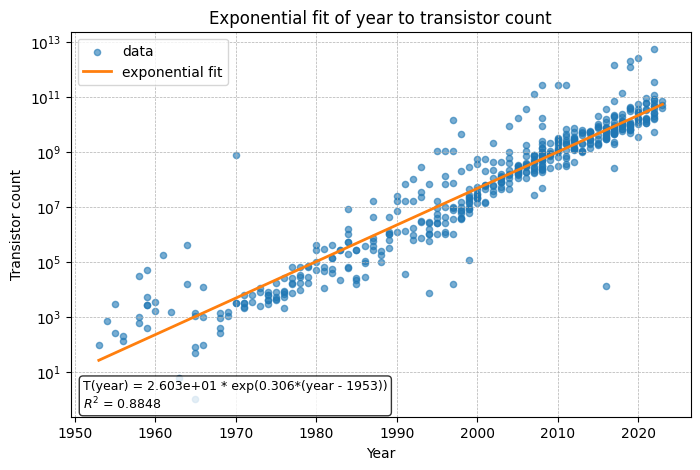

Doubling time = 2.26 years


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = r"/workspaces/computational_methods_course/data/moores.csv"
df_moore = pd.read_csv(path, header=1)

x_pos = pd.to_numeric(df_moore['Year'], errors='coerce').values
y = pd.to_numeric(
    df_moore['Transistor Count'].astype(str).str.replace(r'[^\d.]', '', regex=True),
    errors='coerce'
).values

x = x_pos.copy()
y_vals = y.copy()
mask = (y > 0) & np.isfinite(y)
x = x_pos[mask].astype(float)
y_vals = y[mask].astype(float)

# reference year
x0 = x.min()
X = x - x0

# linear fit on log(y) -> ln(y) = ln(a) + b*(year - x0)
ln_y = np.log(y_vals)
b, ln_a = np.polyfit(X, ln_y, 1)
a = np.exp(ln_a)

# fitted curve and R^2 (on log scale)
xs = np.linspace(x.min(), x.max(), 500)
ys_fit = a * np.exp(b * (xs - x0))

ln_y_pred = ln_a + b * X
ss_res = np.sum((ln_y - ln_y_pred) ** 2)
ss_tot = np.sum((ln_y - np.mean(ln_y)) ** 2)
r2 = 1 - ss_res / ss_tot

# plot
plt.figure(figsize=(8,5))
plt.scatter(x, y_vals, s=20, alpha=0.6, label='data')
plt.plot(xs, ys_fit, color='C1', lw=2, label='exponential fit')
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Transistor count')
eq_text = f"T(year) = {a:.3e} * exp({b:.3f}*(year - {int(x0)}))\n$R^2$ = {r2:.4f}"
plt.title('Exponential fit of year to transistor count')
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.annotate(eq_text, xy=(0.02, 0.02), xycoords='axes fraction', fontsize=9,
             bbox=dict(boxstyle='round', fc='w', alpha=0.8))
plt.show()

#now compute doubling time
try:
    slope = b
except NameError:
    x0 = x.min()
    X = x - x0
    ln_y = np.log(y_vals)
    slope, ln_a = np.polyfit(X, ln_y, 1)

if slope <= 0:
    print("Fit slope <= 0: doubling time is not positive.")
else:
    doubling_time = np.log(2) / slope
    print(f"Doubling time = {doubling_time:.2f} years")

Compared with "2 years" as cited from Wikipedia.

# Question 3 - Row vs. Column

Let's create the array first...

In [6]:
import numpy as np
np.random.seed(42)
arr = np.random.normal(loc=0.0, scale=1.0, size=(10_000, 10_000)).astype(np.float32)
print(arr.shape, arr.dtype)

(10000, 10000) float32


Define row and column major summing functions for both python and numpy:

In [7]:
import numpy as np

def sum_row_major(arr: np.ndarray) -> float:
    total = 0.0
    nrows, ncols = arr.shape
    for i in range(nrows):
        for j in range(ncols):
            total += arr[i, j]
    return total

def sum_column_major(arr: np.ndarray) -> float:
    total = 0.0
    nrows, ncols = arr.shape
    for j in range(ncols):
        for i in range(nrows):
            total += arr[i, j]
    return total

def sum_numpy(arr):
    return arr.sum()               # uses C loops and row-major storage

def sum_numpy_forced_col(arr):
    return np.asfortranarray(arr).sum()  # same operation, but column-major storage


Now let's try 'em out!

In [8]:
import timeit as tm

n_runs = 30

row_times = tm.repeat("sum_row_major(arr)", globals=globals(), repeat=n_runs, number=1)
col_times = tm.repeat("sum_column_major(arr)", globals=globals(), repeat=n_runs, number=1)
np_times  = tm.repeat("sum_numpy(arr)",      globals=globals(), repeat=n_runs, number=1)
f_times   = tm.repeat("sum_numpy_forced_col(arr)", globals=globals(), repeat=n_runs, number=1)

def avg(x): return sum(x)/len(x)

print(f"Row-major loop avg:        {avg(row_times):.4f} s")
print(f"Column-major loop avg:     {avg(col_times):.4f} s")
print(f"NumPy arr.sum() avg:       {avg(np_times):.4f} s")
print(f"NumPy sum() (Fortran) avg: {avg(f_times):.4f} s")

print(f"\nColumn/Row slowdown:       {avg(col_times)/avg(row_times):.2f}x")
print(f"Row/NumPy slowdown:        {avg(row_times)/avg(np_times):.2f}x")
print(f"Col/NumPy slowdown:        {avg(col_times)/avg(np_times):.2f}x")

Row-major loop avg:        14.1505 s
Column-major loop avg:     13.8345 s
NumPy arr.sum() avg:       0.0226 s
NumPy sum() (Fortran) avg: 0.1701 s

Column/Row slowdown:       0.98x
Row/NumPy slowdown:        625.52x
Col/NumPy slowdown:        611.55x


The Python loop implementations are extremely slow because they process each array element one at a time in the Python interpreter, while numpy’s sum() runs the same operation in C (a faster lower level language). This makes NumPy hundreds of times faster. The row-major and column-major loops take nearly the same time because Python’s per-element overhead dominates the runtime.

# Question 4 - Scaling and Parallel Computing

Making a function that constructs a large, lazy Dask array of random numbers then returning the z-score normalized version.

In [9]:
import time
import numpy as np
import dask.array as da
import dask
from dask.diagnostics import ProgressBar

def make_zscore_dask_array(n, m, chunks=(2000, 2000), seed=42, dtype=np.float32):
    rs = da.random.RandomState(seed)
    x = rs.random((n, m), chunks=chunks).astype(dtype)

    mu = x.mean()
    sigma = x.std()

    z = (x - mu) / sigma
    return z


Now let's build a function that sets up the steps for this z-score array, then computes it and records time.

In [10]:
def time_compute_zscore(n, m, num_workers=1, chunks=(2000, 2000), scheduler="threads"):
    """
    Build z-score graph and compute it, measuring wall time.
    scheduler: "threads" is typical for Dask arrays (NumPy releases GIL in many ops).
    """
    with dask.config.set(scheduler=scheduler, num_workers=num_workers):
        z = make_zscore_dask_array(n, m, chunks=chunks)

        t0 = time.perf_counter()
        with ProgressBar():
            _ = z.compute()  # triggers computation
        t1 = time.perf_counter()

    return t1 - t0


Now let's run the same fixed-size z-score computation on a large array using 1 to 4 CPU cores and measure how the runtime decreases as more cores are used. Then we will compute speed-up and parallel efficiency to look at the scaling.

[########################################] | 100% Completed | 4.23 sms
Strong scaling: workers=1, time=4.415 s
[########################################] | 100% Completed | 2.63 sms
Strong scaling: workers=2, time=2.642 s
[########################################] | 100% Completed | 2.24 sms
Strong scaling: workers=3, time=2.257 s
[########################################] | 100% Completed | 2.35 sms
Strong scaling: workers=4, time=2.364 s

Strong scaling results:
p=1: T(p)=4.415 s, S(p)=1.00, E(p)=1.00
p=2: T(p)=2.642 s, S(p)=1.67, E(p)=0.84
p=3: T(p)=2.257 s, S(p)=1.96, E(p)=0.65
p=4: T(p)=2.364 s, S(p)=1.87, E(p)=0.47


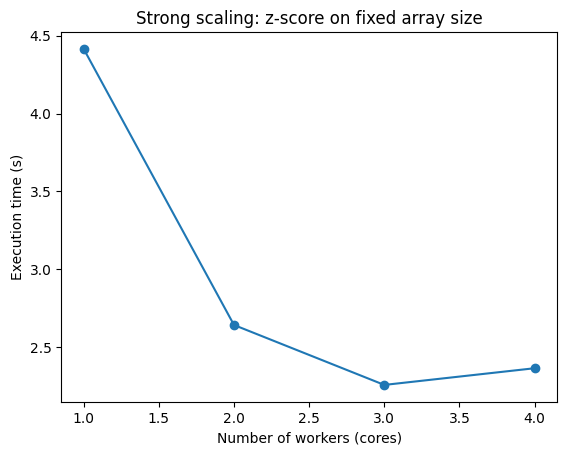

In [11]:
# Strong scaling parameters
N, M = 20_000, 20_000
chunks = (2000, 2000)
workers_list = [1, 2, 3, 4]

times_strong = []
for p in workers_list:
    t = time_compute_zscore(N, M, num_workers=p, chunks=chunks, scheduler="threads")
    times_strong.append(t)
    print(f"Strong scaling: workers={p}, time={t:.3f} s")

T1 = times_strong[0]
speedup = [T1 / tp for tp in times_strong]
efficiency = [sp / p for sp, p in zip(speedup, workers_list)]

print("\nStrong scaling results:")
for p, tp, sp, ep in zip(workers_list, times_strong, speedup, efficiency):
    print(f"p={p}: T(p)={tp:.3f} s, S(p)={sp:.2f}, E(p)={ep:.2f}")

import matplotlib.pyplot as plt

plt.figure()
plt.plot(workers_list, times_strong, marker="o")
plt.xlabel("Number of workers (cores)")
plt.ylabel("Execution time (s)")
plt.title("Strong scaling: z-score on fixed array size")
plt.show()


As the number of CPU cores increases from 1 to 4, the runtime for the fixed-size z-score computation decreases, but the improvement slows down after 2 cores. The speedup is close to ideal when going from 1 to 2 cores. Beyond that, additional cores give diminishing returns because the computation becomes limited by factors such as memory bandwidth.

Now let's increase the array size as we add more cores to try and make it so each core does the same amount of lifting. Then we will see if the runtime stays relatively constant.

In [12]:
N0 = 10_000  # base side length for p=1 (adjust if memory is tight)
chunks = (2000, 2000)

times_weak = []
sizes_weak = []

for p in workers_list:
    side = int(N0 * np.sqrt(p))
    n, m = side, side
    sizes_weak.append((n, m))

    t = time_compute_zscore(n, m, num_workers=p, chunks=chunks, scheduler="threads")
    times_weak.append(t)

    print(f"Weak scaling: workers={p}, size={n}x{m}, time={t:.3f} s")


[                                        ] | 0% Completed | 217.28 us

[########################################] | 100% Completed | 1.01 sms
Weak scaling: workers=1, size=10000x10000, time=1.017 s
[########################################] | 100% Completed | 1.42 sms
Weak scaling: workers=2, size=14142x14142, time=1.426 s
[########################################] | 100% Completed | 1.84 sms
Weak scaling: workers=3, size=17320x17320, time=1.852 s
[########################################] | 100% Completed | 2.24 sms
Weak scaling: workers=4, size=20000x20000, time=2.249 s


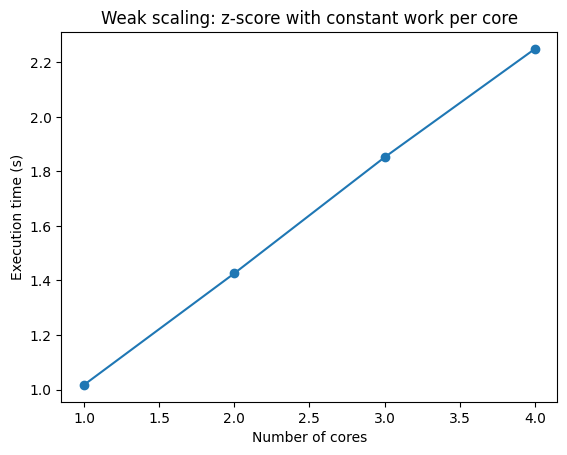


Weak scaling sizes used:
p=1: size=10000x10000, time=1.017 s
p=2: size=14142x14142, time=1.426 s
p=3: size=17320x17320, time=1.852 s
p=4: size=20000x20000, time=2.249 s


In [13]:
plt.figure()
plt.plot(workers_list, times_weak, marker="o")
plt.xlabel("Number of cores")
plt.ylabel("Execution time (s)")
plt.title("Weak scaling: z-score with constant work per core")
plt.show()

print("\nWeak scaling sizes used:")
for p, (n, m), t in zip(workers_list, sizes_weak, times_weak):
    print(f"p={p}: size={n}x{m}, time={t:.3f} s")


So my expectation was that runtime would stay relatively constant... I was wrong. It looks like the overhead from aquiring more cores may be to blame for this increase in execution time.